In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
plt.style.use('ggplot')

from utils import import_data, get_accuracy, get_accuracy_by_cue, plot_accuracy, plot_accuracy_by_cue, save_fig
from supplemental_data import rule_change, cscheme, cue_names, reward_arms

import datetime
timestamp = datetime.datetime.today().strftime("%Y-%m-%d-%H%M%S")

# Import data
Specify the list of all animals and the directory the csv files are. Choose a subset of animals to work with.

In [2]:
def import_data(datadir, animal):
    """
    Takes the data directory and animal name in format JC2xx as an input, and imports the data 
    from a csv file into a dataframe.

    Parameters
    ----------
    datadir : the directory that contains the csv files for each animal.
    animal : a string with the animal name in JC2xx format.

    Returns
    -------
    data : a dictionary of dataframes with data for each animal.
    
    """
    
    path = datadir+animal+'_data.csv'
    data = pd.read_csv(path)
    
    return data

In [3]:
all_animals = [
    'JC240',
    'JC241',
    'JC258',
    'JC274',
    'JC283',
    'JC315',
    'JC267',
]

datadir = 'data/'

# Plot only subset of animals
animals = all_animals[2:6]

Import animal data and store them in a dict under animal name.

In [4]:
data = {}

for animal in animals:
    data[animal] = import_data(datadir,
                               animal)

Get the number of training days for each animal.

In [5]:
sessions = {}

for animal in animals:
    sessions[animal] = data[animal]['Session_ID'].unique()

Calculate the accuracy for each training day.

In [6]:
accuracy = {}

for animal in animals:
    accuracy[animal] = get_accuracy(data,
                                    animal)

Get the unique food cues for each experiment. Calculate the accuracy by training day and food cue type.

In [7]:
cues = {}
accuracy_by_cue = {}

for animal in animals:
    cues[animal] = data[animal]['Flavor'].unique()
    accuracy_by_cue[animal] = get_accuracy_by_cue(data,
                                                  animal)

# Plot performance

## Plot accuracy for all animals
Toggle between 2-cue or 3-cue (before and after the rule change).

In [8]:
ndays2cue = max(rule_change.values())-1 # x-val is the maximum value of the rule change day minus one day
ndays3cue = np.max(np.concatenate(list(sessions.values()))) # plot max value for all sessions and all animals

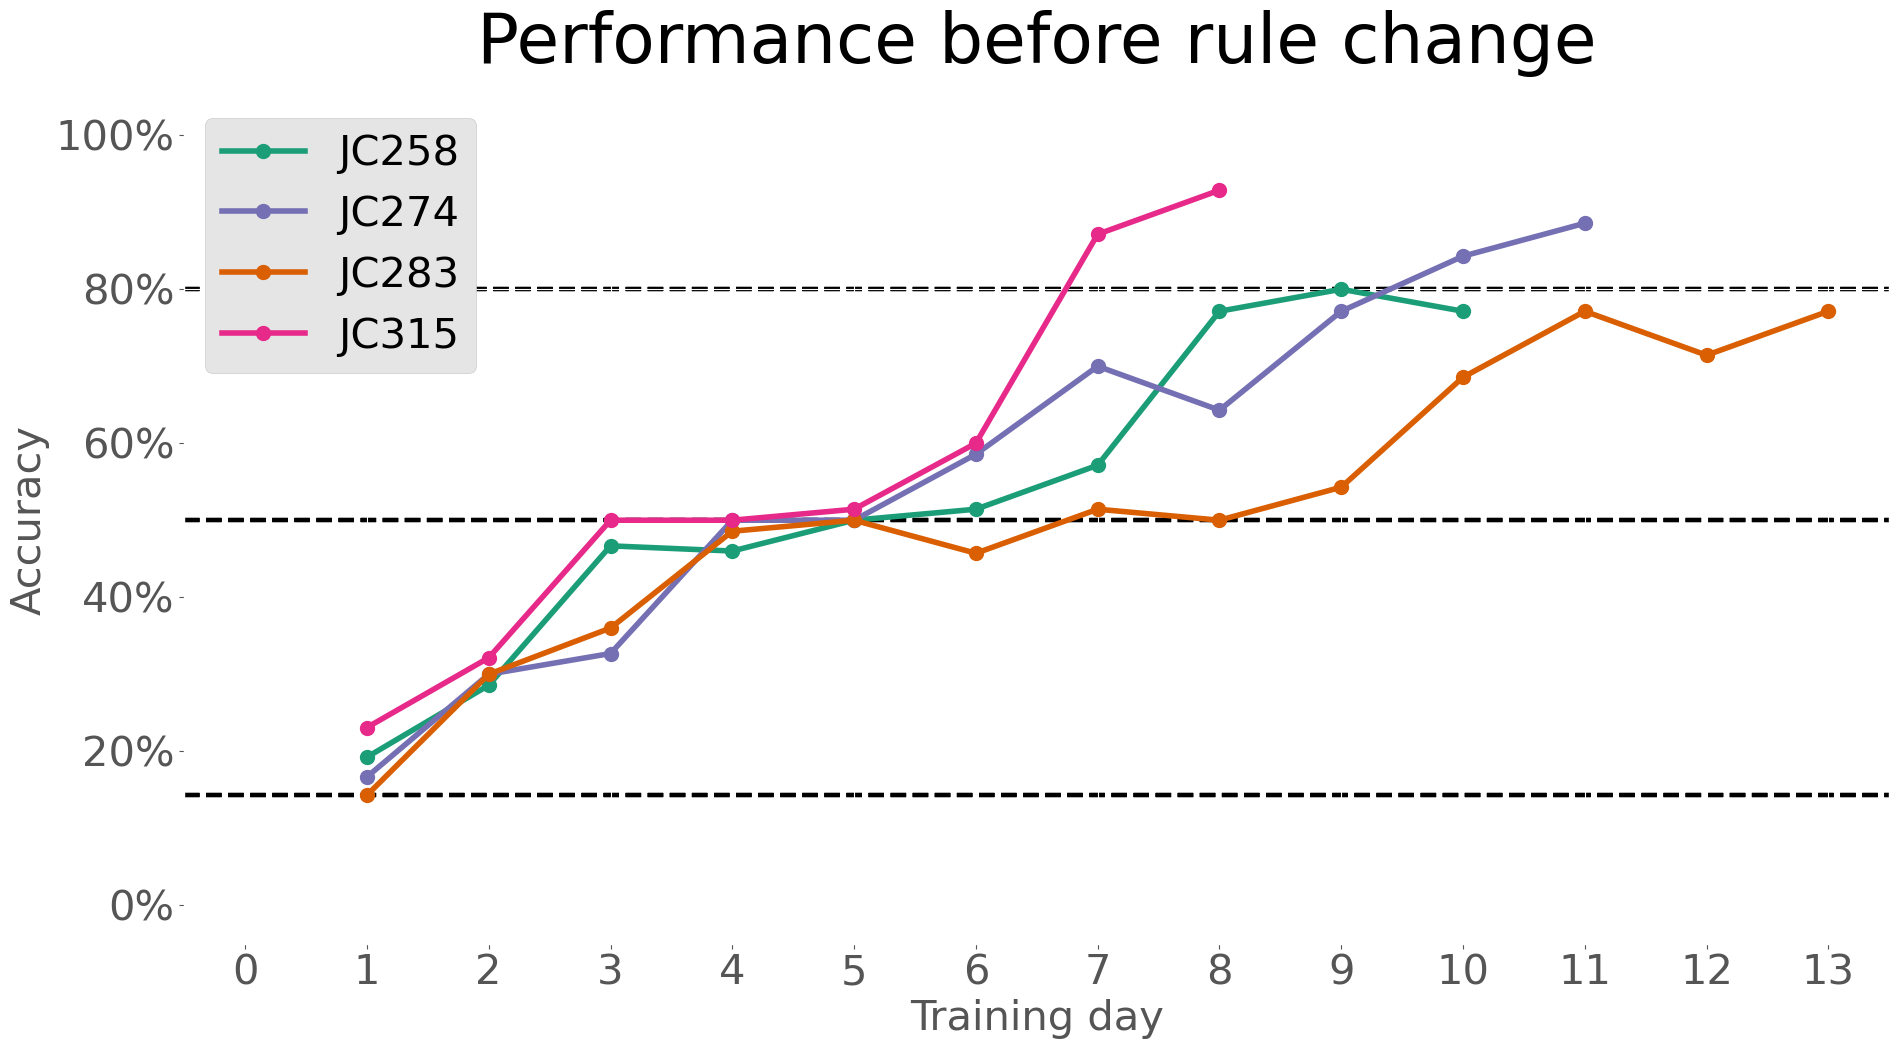

In [9]:
fig, ax = plt.subplots(figsize=(22,11))

for animal in animals:
    
    ############# TOGGLE VARIABLES #################
    # 2 cues
    acc = accuracy[animal].iloc[:rule_change[animal]-1] # accuracy before rule change
    title='Performance before rule change'
    ndays=ndays2cue
    
    # # 3 cues
    # acc = accuracy[animal].iloc[:rule_change[animal]] # accuracy after rule change
    # title='Performance after rule change'
    # ndays=ndays3cue
    
    ################################################
    
    
    plot_accuracy(
        acc,
        animal,
        ndays=ndays,
        title=title,
        fig=fig,
        ax=ax
    )

plt.show()
# save_fig('Performance 2cues', 'svg')

## Plot performance by cue type (all animals)
Toggle between 2-cue or 3-cue (before and after the rule change).

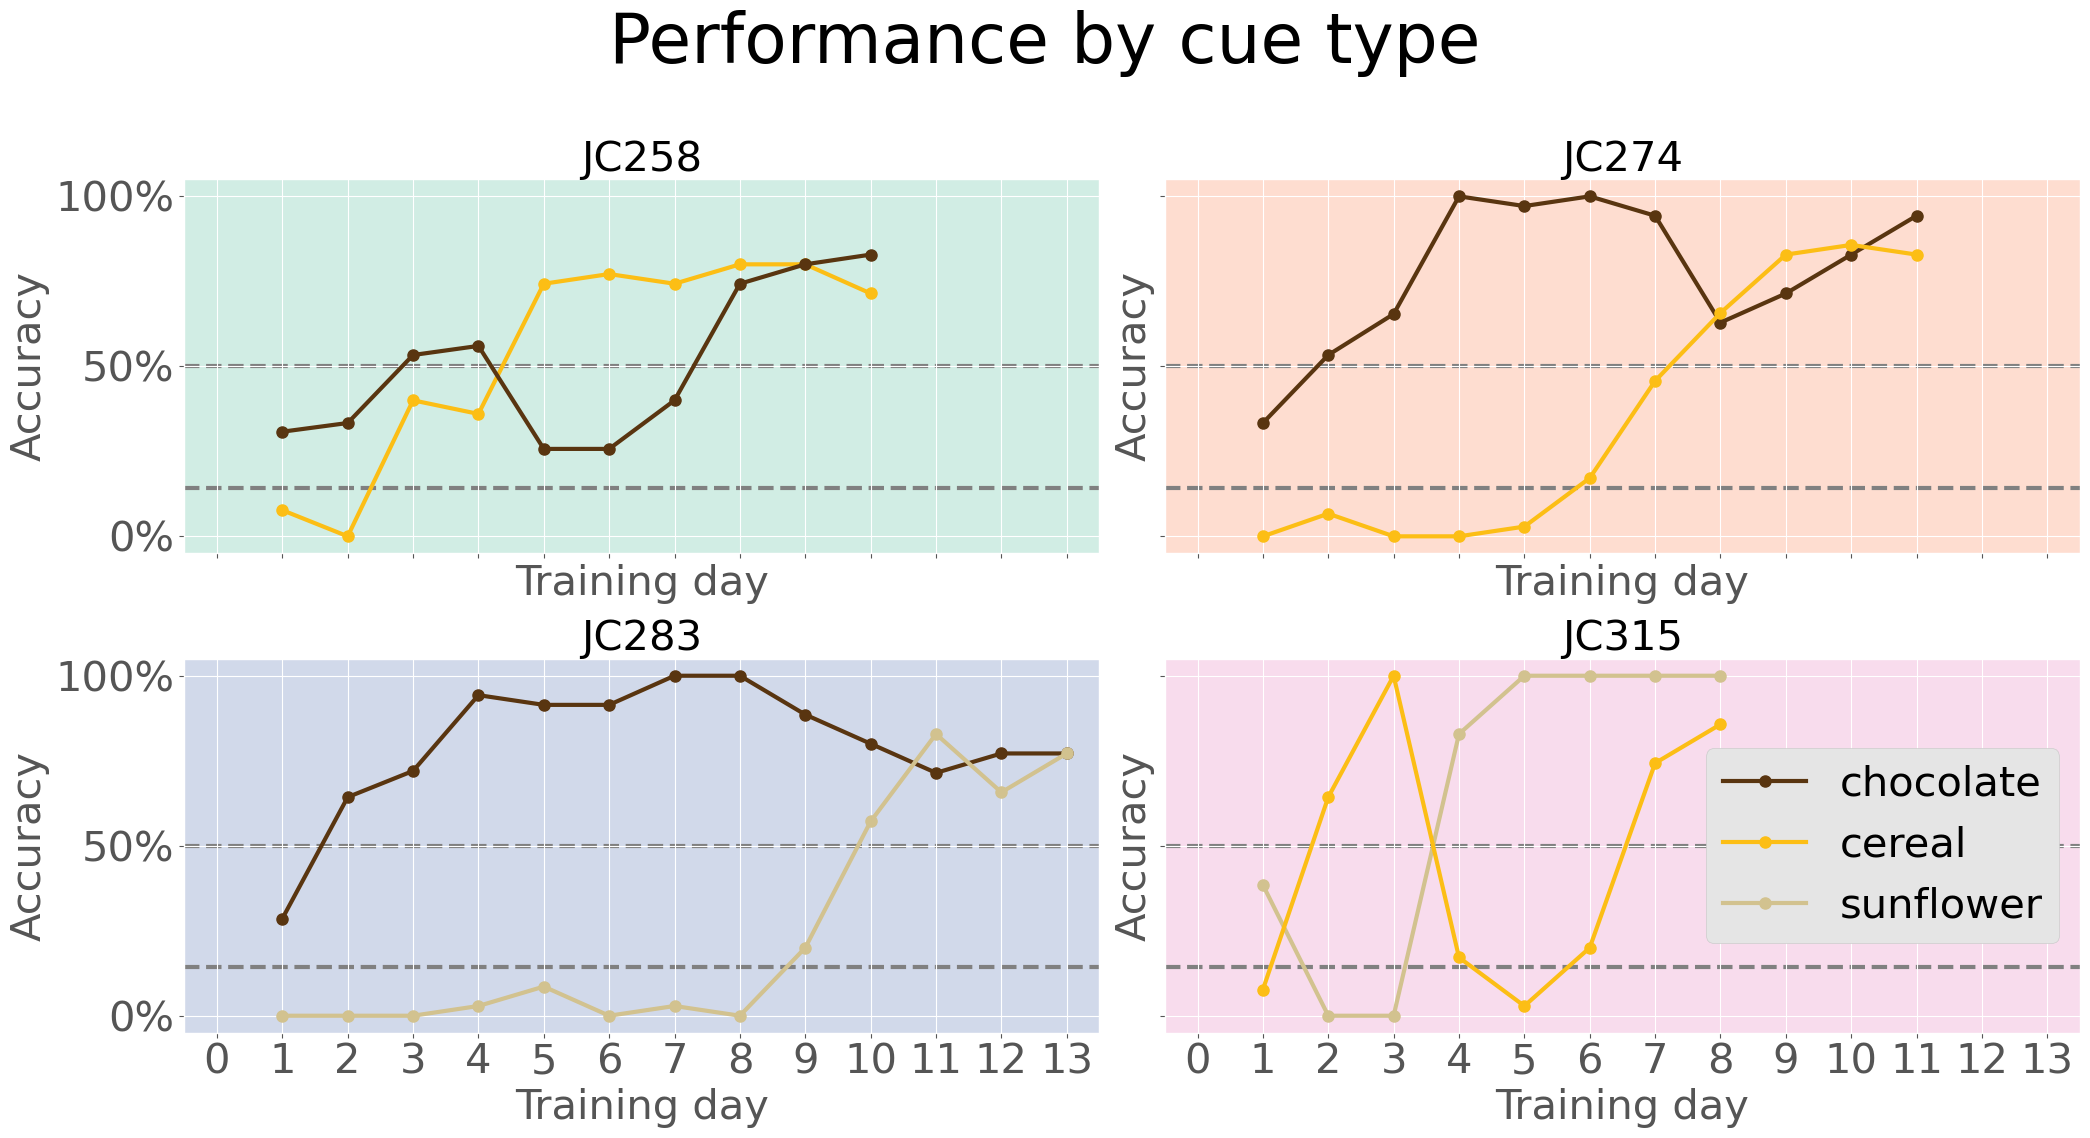

In [10]:
# Make a large plot with 4 subplots
rows, cols = 2, 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(21,11))
title='Performance by cue type'
fig.suptitle(title, fontsize=50, y=1.03)

# Iterate over each subplot and plot.
for ax, animal in zip(axes.flatten(), animals):
    
    ############# TOGGLE VARIABLES #################
    # 2 cue
    data_by_cue = accuracy_by_cue[animal].loc[:rule_change[animal]-1]
    ndays=ndays2cue
    cues_select=cues[animal][:2]
    rule_ch_line=False
    
    # # 3 cue
    # data_by_cue = accuracy_by_cue[animal]
    # ndays=ndays3cue
    # cues_select=cues[animal]
    # rule_ch_line=True
    ###############################################
    
    plot_accuracy_by_cue(
        data_by_cue=data_by_cue,
        animal=animal,
        cues=cues_select,
        ndays=ndays,
        background=cscheme[animal+'_medium'],
        fig=fig,
        ax=ax,
        rule_ch_line=rule_ch_line,
    )
    
    # Plot legend on JC315 subplot
    if animal == 'JC315':
        legend_handles = []
        for cue, color in cue_names.items():
            legend_handles.append(plt.Line2D([],[], color=color, label=cue, linewidth=3, marker='o', markersize=8))
        ax.legend(handles=legend_handles, loc=7, fontsize=30, framealpha=1)
        
plt.show()
# save_fig('Performance all animals medium tint', 'svg')

## Plot performance by cue type (individual animal)
Toggle between 2-cue or 3-cue

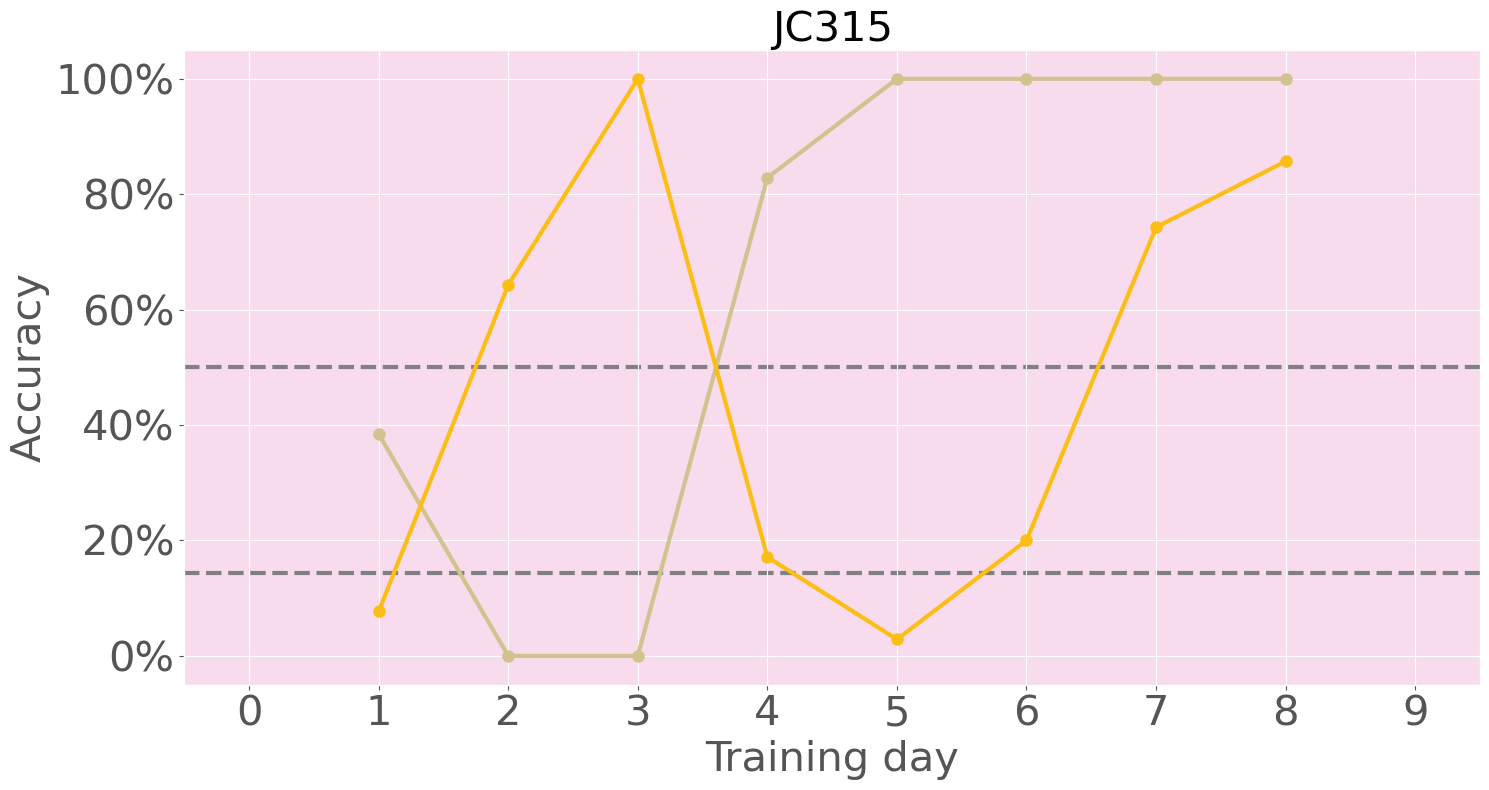

In [11]:
animal='JC315'

############# TOGGLE VARIABLES #################
# 2 cues
data_by_cue = accuracy_by_cue[animal].loc[:rule_change[animal]-1] # accuracy before rule change
ndays=ndays2cue # or rule_change[animal]-1
ndays=9
cues_select=cues[animal][:2]

# # 3 cues
# data_by_cue = accuracy_by_cue[animal]
# ndays= ndays3cue # or len(sessions[animal])
# cues_select=cues[animal]
################################################

plot_accuracy_by_cue(
    data_by_cue=data_by_cue,
    animal=animal,
    cues=cues_select,
    ndays=ndays,
    background=cscheme[animal+'_medium']
                    )

# save_fig(f'Performance {animal}', 'svg')

## Plot failed schema learning with JC240

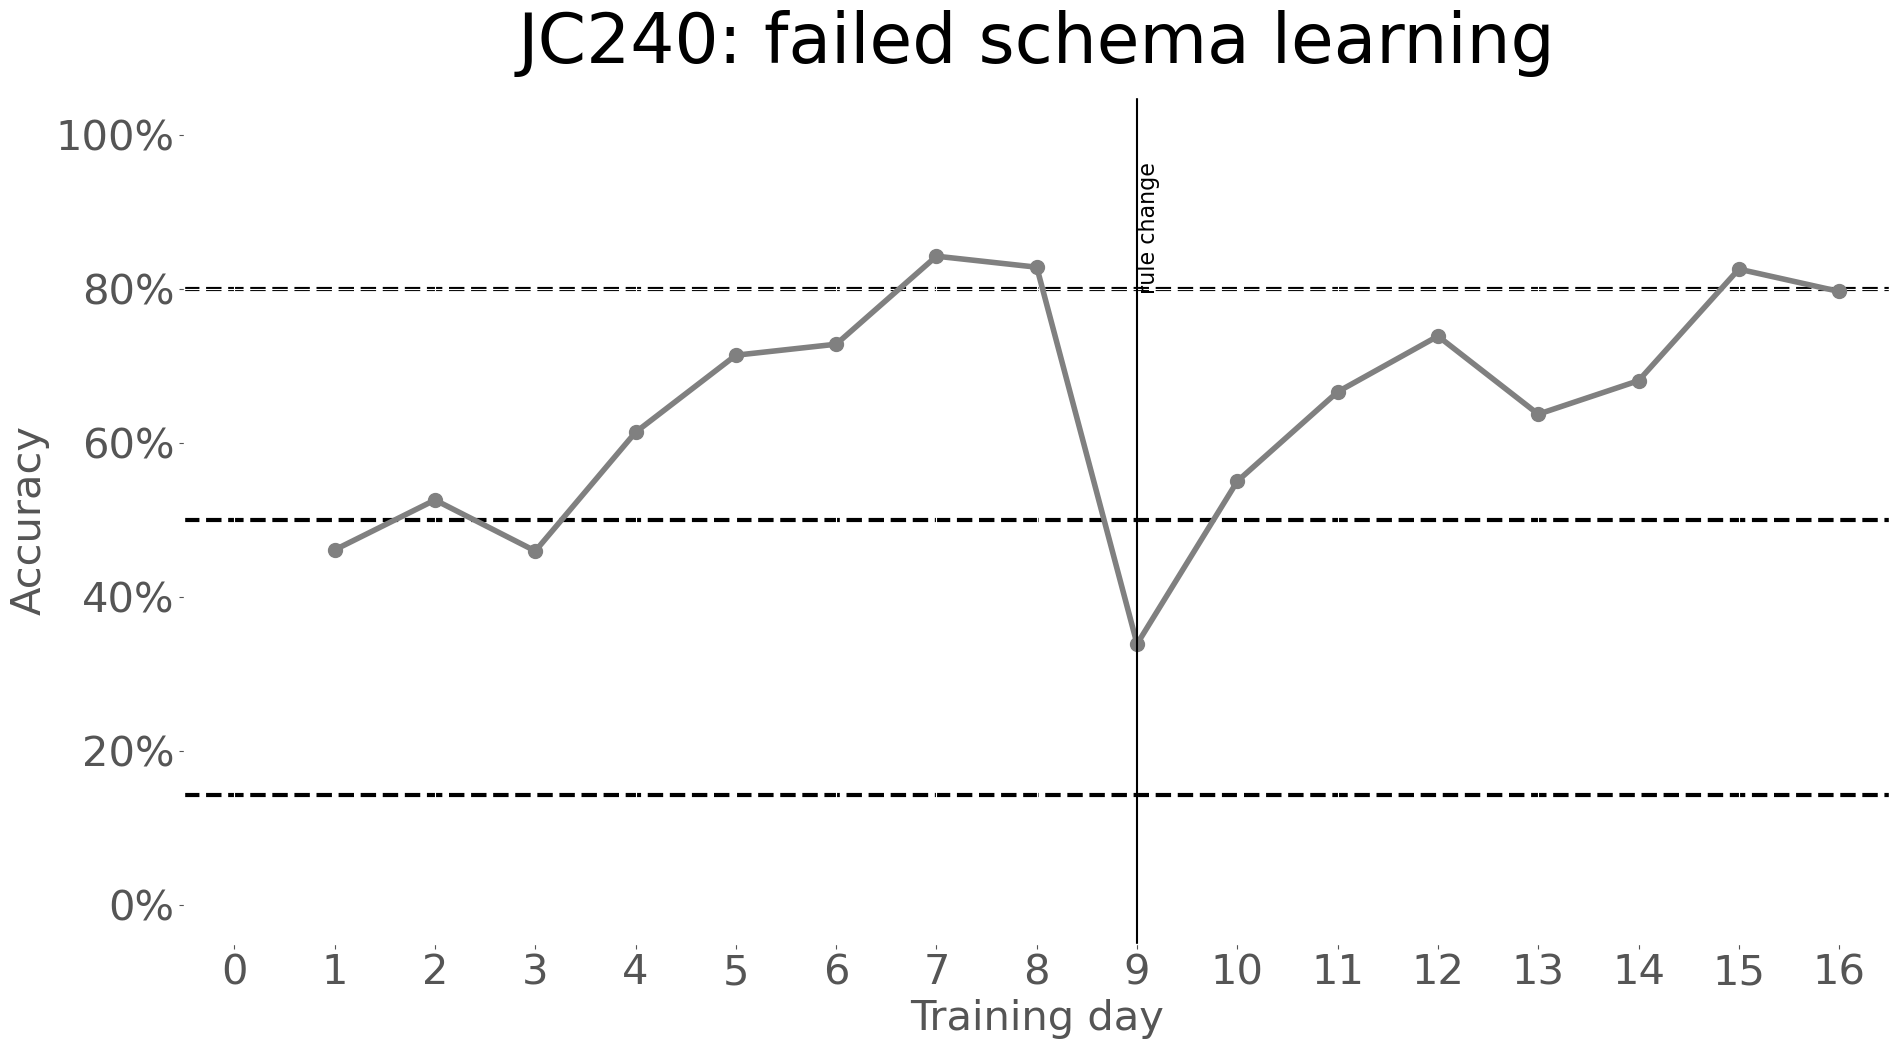

In [12]:
animal = 'JC240'
data_JC240 = {}
data_JC240[animal] = import_data(datadir, animal)
accuracy_JC240 = get_accuracy(data_JC240, animal)

fig, ax = plt.subplots(figsize=(22,11))

plot_accuracy(accuracy_JC240, animal, title="JC240: failed schema learning", fig=fig, ax=ax, legend=False)
ax.axvline(x = rule_change[animal], c='k')
ax.text(rule_change[animal], 80, "rule change", rotation=90, fontsize=16)

plt.show()
# save_fig('JC240 failed schema learning', 'svg')

# Plot arm selection over time

In [13]:
def get_accuracy(data, animal):
    """
    Returns an array of trial accuracy (% trials correct) by training day.

    Parameters
    ----------
    data : a dictionary of dataframes with data for each animal.
    animal : a string with the animal name in JC2xx format.

    Returns
    -------
    accuracy : returns a dictionary of series with accuracy for each animals.

    """

    # group data by training days
    df = data[animal] # call the dataframe for that animal
    df_grouped = df.groupby('Session_ID')
    
    # for each day, divide the correct trials over the total trials
    correct = df_grouped['CorrectBool'].sum() # count correct trials in each day
    total = df_grouped['CorrectBool'].count() # count total trials in each day
    accuracy = np.round(correct/total*100, 2)
    
    return accuracy

In [14]:
##### Calculate arm choice by session #####
def get_arm_choice(JCxxx, rewardArms):
    # data_JCxxx = str(JCxxx) + "_data" # concatenate strings for variable name
    df = data[animal]
    # data_JCxxx = globals()[data_JCxxx] # convert string to variable
    # bysession_JCxxx = data_JCxxx.groupby("Session_ID") # filter by session ID and create a groupby object
    df_grouped = data[animal].groupby('Session_ID')
    # sessions = bysession_JCxxx["Session_ID"].unique() # list sessions
    arms = rewardArms # list arms of interest
    num_arms = len(arms) # count arms
    arm_choice = np.zeros((len(sessions), num_arms+1)) # make a vector that will hold arm choice for each session
                                                        # and add another column for other arms
    num_trials = np.zeros(len(sessions))
    for session in range(1, len(sessions)+1): # iterate over sessions, starting at 1 instead of 0
        num_trials[session-1] = bysession_JCxxx.get_group(session).count()[0] # count number of trials per session
        for arm in range(num_arms): # iterate over arms by indexing numpy array
            this_session = bysession_JCxxx.get_group(session)
            choices_bool = this_session["Arm"]==(arms[arm]) # Boolean of whether arm was chosen
            count = len(choices_bool[choices_bool==True])
            arm_choice[session-1][arm] = count
        arm_choice[session-1][-1] = num_trials[session-1] - arm_choice[session-1][0] - arm_choice[session-1][1] - arm_choice[session-1][2]
                                    # for last column subtract arms of interest from total trials
    arm_choice = arm_choice / num_trials[:,None] # express arm choice as a proportion of total trials
    return num_trials, arm_choice

In [15]:
# arm_counts_proportion={}

# for animal in animals:
#     df = data[animal]
#     df_grouped = df.groupby('Session_ID')
#     arms = df['Arm'].unique()
#     num_trials = df_grouped.size()
#     arm_counts = df_grouped['Arm'].value_counts()
#     arm_counts_proportion[animal]={}
#     for session in sessions[animal]:
#         arm_counts_proportion[animal][session] = arm_counts[session] / num_trials[session]

In [16]:
# arm_proportion = {}

# for animal in animals:
#     df_grouped=data[animal].groupby('Session_ID')
#     arm_counts = df_grouped['Arm'].value_counts()
#     num_trials = df_grouped.size()
    
#     arm_proportion[animal]={}
#     for session in sessions[animal]:
#         arm_proportion[animal][session] = arm_counts[session] / num_trials[session]

In [17]:
arm_proportion = pd.DataFrame(columns=['Animal', 'Session_ID', 'Arm', 'Proportion'])

for animal in animals:
    df_group=data[animal].groupby('Session_ID')
    arm_counts = df_group['Arm'].value_counts()
    num_trials = df_group.size()

    for session in sessions[animal]:
        arm_proportion_val = arm_counts[session] / num_trials[session]
        df_temp = arm_proportion_val.reset_index(name='Proportion') # add a column named proportion
        df_temp.columns = ['Arm', 'Proportion']
        df_temp['Animal'] = animal
        df_temp['Session_ID'] = session
        arm_proportion = pd.concat([arm_proportion, df_temp], ignore_index=True)
    

[8, 3]


/home/andrea/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/tmp/ipykernel_24188/915690037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rewarms['Other'] = df.drop(columns=reward_arms[animal][:2]).sum(axis=1)


<AxesSubplot:xlabel='Session_ID'>

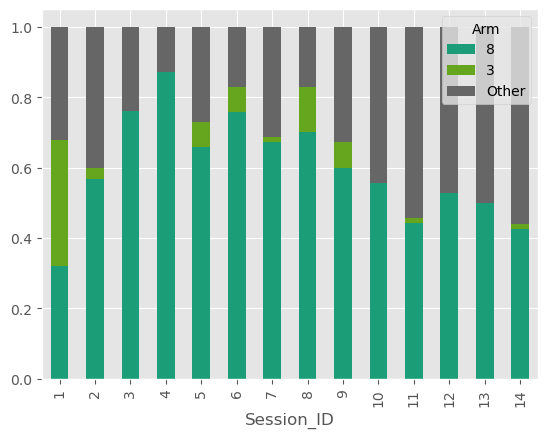

In [19]:
animal='JC283'

print(reward_arms[animal][:2])

df = arm_proportion[arm_proportion['Animal']==animal]
df = df.pivot(index='Session_ID', columns='Arm', values='Proportion')
df_rewarms = df[reward_arms[animal][:2]]
df_rewarms['Other'] = df.drop(columns=reward_arms[animal][:2]).sum(axis=1)


df_rewarms.plot(kind='bar', stacked=True, colormap='Dark2')

In [20]:
animals

['JC258', 'JC274', 'JC283', 'JC315']

[3, 7]
[8, 4]


/home/andrea/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/tmp/ipykernel_24188/3334613936.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rewarms['Other'] = df.drop(columns=reward_arms[animal][:2]).sum(axis=1)
/home/andrea/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/tmp/ipykernel_24188/3334613936.py:10: SettingWithCopyWarning: 
A value is try

[8, 3]
[3, 4]


/home/andrea/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/tmp/ipykernel_24188/3334613936.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rewarms['Other'] = df.drop(columns=reward_arms[animal][:2]).sum(axis=1)
/home/andrea/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/tmp/ipykernel_24188/3334613936.py:10: SettingWithCopyWarning: 
A value is try

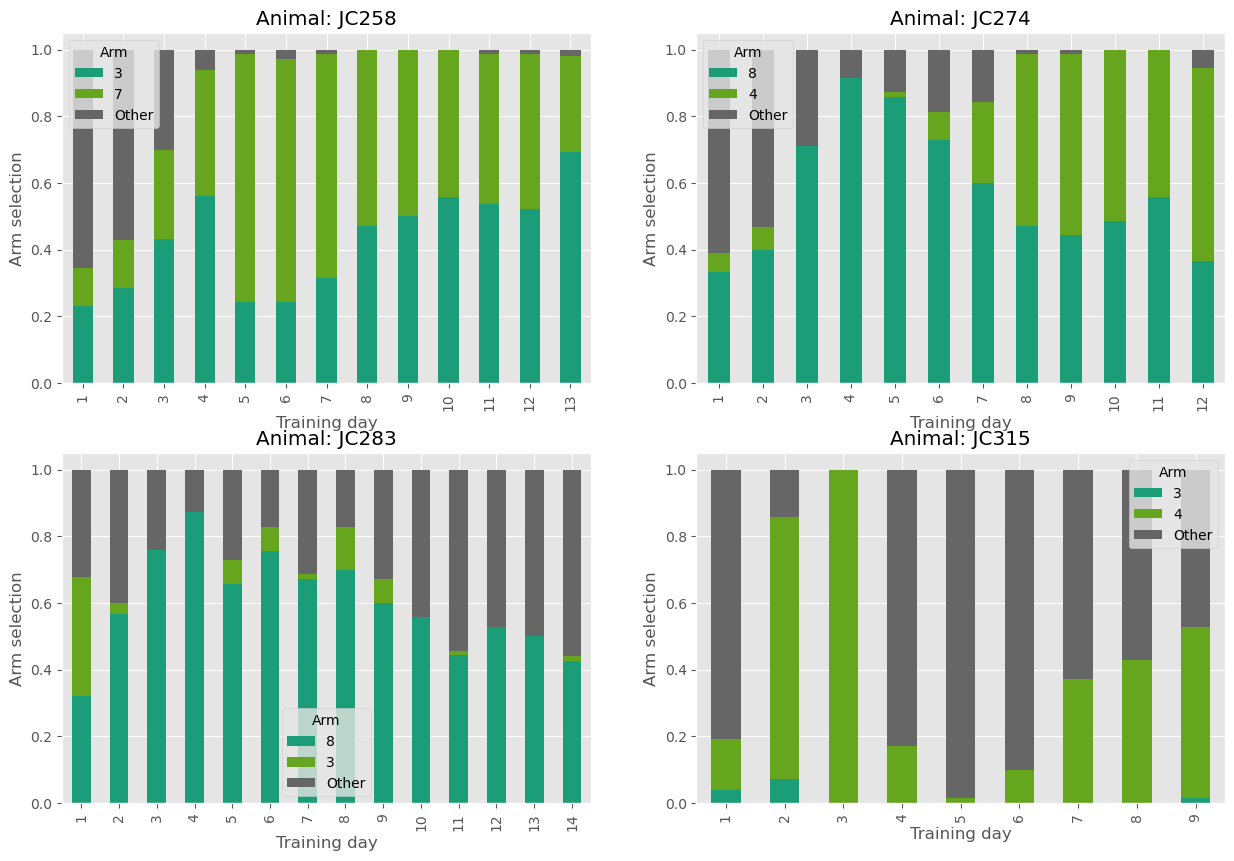

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes=axes.flatten()

for ii, animal in enumerate(animals):
    print(reward_arms[animal][:2])
    
    df=arm_proportion[arm_proportion['Animal']==animal]
    df = df.pivot(index='Session_ID', columns='Arm', values='Proportion')
    df_rewarms = df[reward_arms[animal][:2]]
    df_rewarms['Other'] = df.drop(columns=reward_arms[animal][:2]).sum(axis=1)
    
    df_rewarms.plot(kind='bar', stacked=True, colormap='Dark2', ax=axes[ii])
    axes[ii].set_title(f'Animal: {animal}')
    axes[ii].set_ylabel('Arm selection')
    axes[ii].set_xlabel('Training day')